<a href="https://colab.research.google.com/github/rubenguerra/hello_world/blob/master/algoritmo_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # % version de tensorflow solo de Colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
# SE CARGA EL DATASET
# DESDE CENTER FOR MACHINE PERCEPTION DE LA UNIVERSIDAD CHECA DE PRAGA

_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                     origin=_URL,
                                     extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

In [0]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  
  w = tf.shape(image)[1]
  
  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]
  
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  
  return input_image, real_image

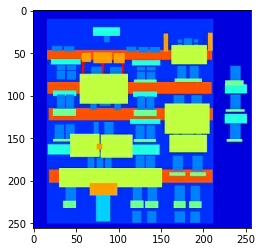

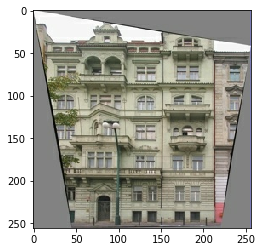

In [39]:
inp, re = load(PATH+'train/100.jpg')
# se hace un casting a entero para que matplotlib lo muestre como imagen
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [0]:
#FUNCIÓN QUE REDIMENSIONA LAS IMAGENES

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  return input_image, real_image

In [0]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
    stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  
  return cropped_image[0], cropped_image[1]

In [0]:
#Normalizando las imágenes a [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  
  return input_image, real_image

In [0]:
@tf.function()
def random_jitter(input_image, real_image):
  # REDIMENSIONANDO LAS IMAGENES A 286 x 283 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)
  
  input_image, real_image = random_crop(input_image, real_image)
  
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
    
  return input_image, real_image

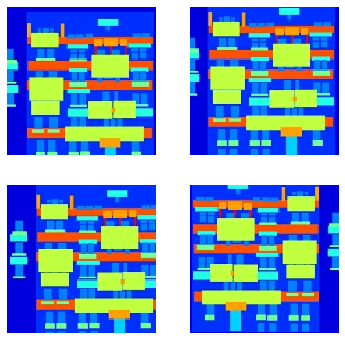

In [44]:
"""
Se realiza un random jittering que consiste en:
1.- Redimensionado de la imagen aumentando su altura y anchura
2.- Recorte aleatorio del tamaño original
3.- Reflejado aleatorio de la imagen horizontalmente
"""

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()


In [0]:
## FUNCION QUE CARGA LAS IMÁGENES PARA EL ENTRENAMIENTO

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  
  return input_image, real_image

In [0]:
## FUNCIÓN QUE CARGA LAS IMAGENES PARA LA PRUEBA

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                  IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  
  return input_image, real_image

In [0]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                 num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE)
train_dataset = train_dataset.batch(1)

In [0]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [0]:
### CRONSTRUYENDO EL GENERADOR
"""
La arquitectura del generador es una U-Net modificada
Cada bloque en el codificador es CONV -> BATCHNORM -> LEAKY RELU
Cada bloque en el decodificador es TRANSPOSED CONV -> BATCHNORM -> DROPOUT (aplicado
  a los primeros tres bloques) -> RELU
Existen saltos de conexión entre el codificador y el decodificador (como en U-Net)
"""

OUTPUT_CHANNELS = 3

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                          kernel_initializer=initializer, use_bias=False))
  
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
    
  result.add(tf.keras.layers.LeakyReLU())
  
  return result

In [51]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.2)
  
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                   padding='same',
                                   kernel_initializer=initializer,
                                   use_bias=False))
  
  result.add(tf.keras.layers.BatchNormalization())
  
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
    
    
  result.add(tf.keras.layers.ReLU())
  
  return result

In [53]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [0]:
## LA FUNCIÓN GENERADOR

def Generator():
  down_stack = [
      downsample(64, 4, apply_batchnorm=False), #(bs, 128, 128, 64)
      downsample(128, 4), # (bs, 64, 64, 128)
      downsample(256, 4), # (bs, 32, 32, 256)
      downsample(512, 4), # (bs, 16, 16, 512)
      downsample(512, 4), # (bs, 8, 8, 512)
      downsample(512, 4), # (bs, 4, 4, 512)
      downsample(512, 4), # (bs, 2, 2, 512)
      downsample(512, 4), # (bs, 1, 1, 512)
  ]
  
  
  up_stack = [
      upsample(521, 4, apply_dropout=True), # (bs, 2, 2, 1024)
      upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
      upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
      upsample(512, 4), # (bs, 16, 16, 1024)
      upsample(256, 4), # (bs, 32, 32, 512)
      upsample(128, 4), # (bs, 64, 64, 256)
      upsample(64, 4), # (bs, 128, 128, 128)
  ]
  
  
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        activation='tanh') # (bs, 256, 256, 3)
  
  concat = tf.keras.layers.Concatenate()
  
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs
  
  # Bajando a través del modelo
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
    
  skips = reversed(skips[:-1])
  
  
  # Subiendo y estableciendo el salto de conexión
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])
    
    
  x = last(x)
  
  return tf.keras.Model(inputs=inputs, outputs=x)
  
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


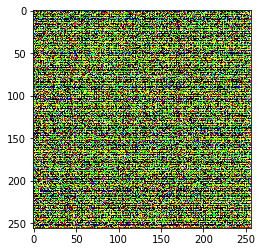

In [55]:
generator = Generator()

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [0]:
## CONTRUIR EL DISCRIMINADOR
"""
*  El discriminador es una PatchGAN
*  Cada bloque en el discriminador es CONV -> BATCHNORM -> LEAKY RELU
*  La forma de la salida despues de la ultima capa es (batch_size, 30, 30, 1)
*  Cada lote de 30 x 30 de la salida clasifica una porción de 70x70 de la imagen
   de entrada
*  El discriminador recibe dos entradas:
    Image de entrada e imagen blanco, la cual es clasificada comom real
    Imagen de entrada e imagen generada (luego del generador), la cual es
    clasificada como falsa
    Concatenamos estos dos puntos juntos en el codigo(tf.concat([inp, tar], axis=1))
    
"""


def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  
  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
  
  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
  
  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4) (down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4) (down2) # (bs, 32, 32, 256)
  
  
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                               kernel_initializer=initializer,
                               use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
  
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
  
  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                               kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
  return tf.keras.Model(inputs=[inp, tar], outputs=last)


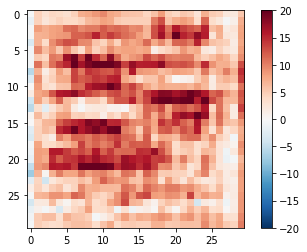

In [57]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [0]:
## DEFINIENDO LA FUNCIÓN DE PÉRDIDA Y EL OPTIMIZADOR

LAMBDA = 100

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  # Media del error absoluto
  
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
## CREANDO UN CHECKPOINT

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [0]:
## DESPUES D ENTRENAR EL MODELO SE CREAN LAS IMAGENES

EPOCHS = 60

In [0]:
## FUNCIÓN PARA GENERAR LAS IMAGENES

def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Imagen de entrada', 'Fachada real', 'Imagen predicha']
  
  
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [0]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    
    
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    
    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    
  generator_gradients = gen_tape.gradient(gen_loss,
                                         generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                              discriminator.trainable_variables)
  
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                         generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                             discriminator.trainable_variables))

In [0]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()
    
    #ENTRENAMIENTO
    for input_image, target in train_ds:
      train_step(input_image, target)
      
      
    clear_output(wait=True)
    
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
      
      
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      
    print('Tiempo tomado por la epoca {} es {} sec\n'.format(epoch + 1,
                                                            time.time()-start))

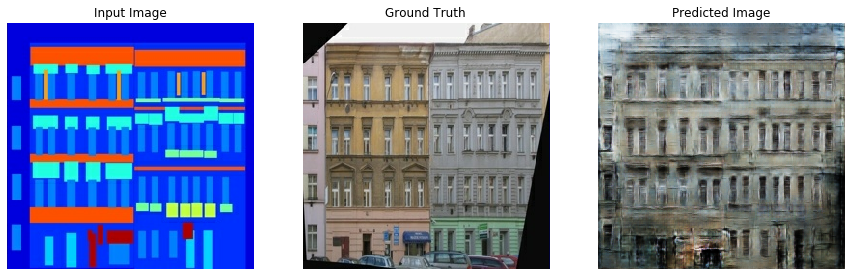

Tiempo tomado por la epoca 60 es 22.57520818710327 sec



In [68]:
fit(train_dataset, EPOCHS, test_dataset)

In [69]:
!ls {checkpoint_dir}

checkpoint		    ckpt-3.data-00000-of-00002
ckpt-1.data-00000-of-00002  ckpt-3.data-00001-of-00002
ckpt-1.data-00001-of-00002  ckpt-3.index
ckpt-1.index		    ckpt-4.data-00000-of-00002
ckpt-2.data-00000-of-00002  ckpt-4.data-00001-of-00002
ckpt-2.data-00001-of-00002  ckpt-4.index
ckpt-2.index


In [70]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

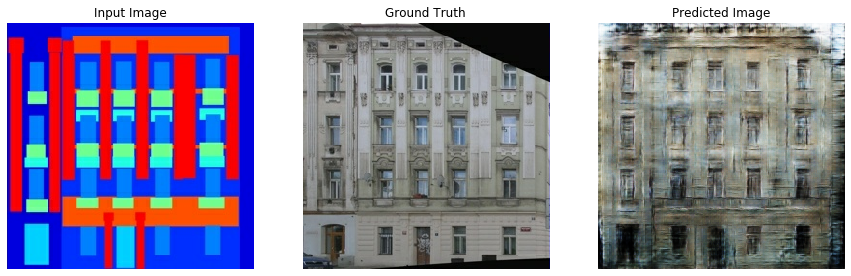

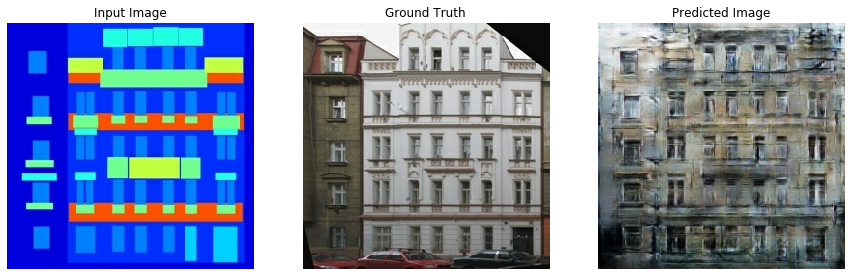

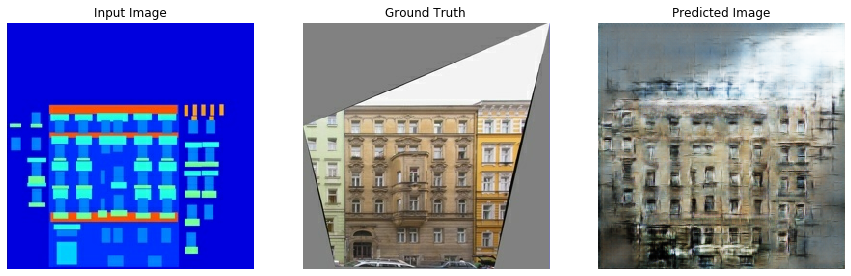

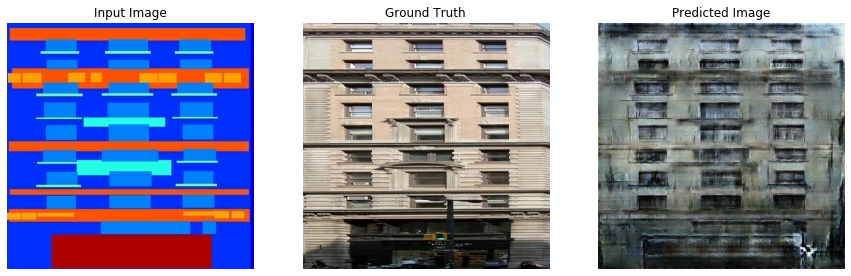

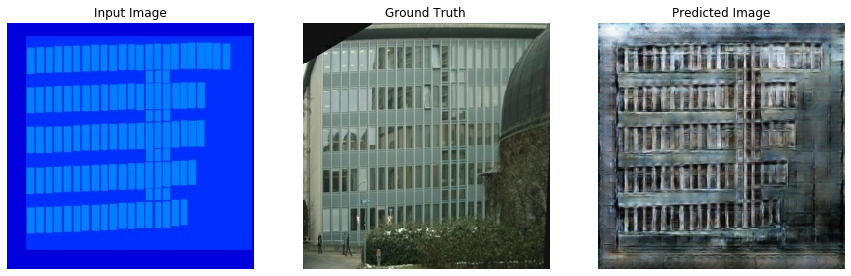

In [71]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)